References:
* https://iopscience.iop.org/article/10.3847/PSJ/ac4f43/pdf
* https://pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/document/venus_radar.pdf -- Level 1 doppler/dely data description
* https://pds-geosciences.wustl.edu/venus/urn-nasa-pds-venus_radar_level2/document/venus_radar_maps_user_guide.pdf -- Level 2 multi-look data description
* https://pubs.usgs.gov/of/1993/0516/report.pdf -- Venus Geologic Mappers' Handbook
* https://echo.jpl.nasa.gov/asteroids/harmon.2002.long.code.pdf -- Details on the long-code doppler-delay method

Tools:
* https://ssd.jpl.nasa.gov/horizons/app.html#/ -- JPL Horizons web app
* https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html -- JPL Horizons Python API

Maps:
* https://www.google.com/maps/space/venus/
* https://en.wikipedia.org/wiki/Mapping_of_Venus
* https://solarsystem.nasa.gov/resources/2342/venus-surface-3d-model/

## Compute Apparent Rotation Angle (Doppler Angle)

In [ ]:
from astropy import units as au
from astropy import coordinates as ac
from astropy import constants as ak
from astropy import time as at
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation
import numpy as np

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

def apparentRotationAngle_poliastro(obstime):
    # Observer point (Arecibo) to ICRS posvel
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    # Venus North Pole
    v = SpheroidLocation(0.0 * au.deg, 90.0 * au.deg, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vNP_fixed = VenusFixed(obstime=obstime,
                           x=x, y=y, z=z,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    VenusICRS(obstime=obstime) # HACK WORKAROUND

    vBC_o_icrs = vBC_fixed.transform_to(o_icrs)
    vNP_o_icrs = vNP_fixed.transform_to(o_icrs)

    # North Pole axis (in Arecibo frame)
    axis_NP = vNP_o_icrs.cartesian.without_differentials() - vBC_o_icrs.cartesian.without_differentials()
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis (in Arecibo frame)
    axis_BC = vBC_o_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    axis_BC /= axis_BC.norm()
    axis_AR = axis_BC.cross(vBC_o_icrs.velocity - o_icrs.velocity)
    axis_AR /= axis_AR.norm()

    # Project the North Pole axis onto the plane of the sky
    sky_NP = axis_BC.cross(axis_NP.cross(axis_BC))
    sky_NP /= sky_NP.norm()

    # Project the Apparent Rotation axis onto the plane of the sky
    sky_AR = axis_BC.cross(axis_AR.cross(axis_BC))
    sky_AR /= sky_AR.norm()

    # Calculate the angle differnce the two sky-projected axes
    sky_delta_angle = np.arccos(sky_NP.dot(sky_AR) / (sky_NP.norm() * sky_AR.norm()))
    if sky_delta_angle > 90 * au.deg: sky_delta_angle -= 180 * au.deg
    if sky_delta_angle < -90 * au.deg: sky_delta_angle += 180 * au.deg
    return sky_delta_angle

In [ ]:
from astroquery.jplhorizons import Horizons

def apparentRotationAngle_horizons(obstime):
    # Venus points in Arecibo frame:
    # Venus Body Center
    obj = Horizons(id='299',  location='-1 @ 399', epochs=obstime.tdb.jd)
    vBC = obj.vectors()
    # Venus North Pole
    obj = Horizons(id='g: 0, 90, 0 @ 299',  location='-1 @ 399', epochs=obstime.tdb.jd)
    vNP = obj.vectors()

    vBC_pos = ac.CartesianRepresentation(
        x=vBC['x'][0] * vBC['x'].unit,
        y=vBC['y'][0] * vBC['y'].unit,
        z=vBC['z'][0] * vBC['z'].unit)
    vBC_vel = ac.CartesianRepresentation(
        x=vBC['vx'][0] * vBC['vx'].unit,
        y=vBC['vy'][0] * vBC['vy'].unit,
        z=vBC['vz'][0] * vBC['vz'].unit)

    vNP_pos = ac.CartesianRepresentation(
        x=vNP['x'][0] * vNP['x'].unit,
        y=vNP['y'][0] * vNP['y'].unit,
        z=vNP['z'][0] * vNP['z'].unit)
    vNP_vel = ac.CartesianRepresentation(
        x=vNP['vx'][0] * vNP['vx'].unit,
        y=vNP['vy'][0] * vNP['vy'].unit,
        z=vNP['vz'][0] * vNP['vz'].unit)

    # North Pole axis
    axis_NP = vNP_pos - vBC_pos
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis
    axis_PO = vBC_pos
    axis_PO /= axis_PO.norm()
    axis_AR = axis_PO.cross(vBC_vel)
    axis_AR /= axis_AR.norm()

    # Project the North Pole axis onto the plane of the sky
    sky_NP = vBC_pos.cross(axis_NP.cross(vBC_pos))
    sky_NP /= sky_NP.norm()

    # Project the Apparent Rotation axis onto the plane of the sky
    sky_AR = vBC_pos.cross(axis_AR.cross(vBC_pos))
    sky_AR /= sky_AR.norm()

    # Calculate the angle differnce the two sky-projected axes
    sky_delta_angle = np.arccos(sky_NP.dot(sky_AR) / (sky_NP.norm() * sky_AR.norm()))
    if sky_delta_angle > 90 * au.deg: sky_delta_angle -= 180 * au.deg
    if sky_delta_angle < -90 * au.deg: sky_delta_angle += 180 * au.deg
    return sky_delta_angle

## Arecibo Radar Data Processing

In [ ]:
# ! pip3 install --upgrade --quiet astroquery

In [1]:
_interactive = True

In [ ]:
_interactive = False

In [2]:
ROOT_PREFIX = "/mnt/c/Users/natha/Downloads/venus/arecibo_radar/pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/"
DATA_PREFIX = ROOT_PREFIX + "data/"

In [15]:
if _interactive: ## Load real data.
    import numpy as np

    # 1988:
    #filename = "venus_ocp_19880604_163910.img"  # First S (ever!)
    #filename = "venus_ocp_19880620_144220.img"
    #filename = "venus_ocp_19880618_150330.img"
    #filename = "venus_ocp_19880617_151830.img"

    # 2001:
    #filename = "venus_ocp_20010331_160048.img"
    #filename = "venus_ocp_20010331_184848.lbl"

    # 2012: used GBT, maybe avoid for now

    # 2015:
    filename = "venus_ocp_20150810_162629.img"  # First S
    #filename = "venus_ocp_20150810_163623.img"  # Next S
    #filename = "venus_ocp_20150816_171104.img"  # Last S
    #filename = "venus_ocp_20150812_155242.img"  # First N
    #filename = "venus_scp_20150815_172030.img"  # Last N

    # 2017:

    # 2020:
    #filename = "venus_scp_20200530_175421.img"
    #filename = "venus_ocp_20200530_175421.img"
    #filename = "venus_ocp_20200530_174429.img"
    #filename = "venus_ocp_20200530_173437.img"
    #filename = "venus_ocp_20200530_172445.img"

    # Vertical roll experiments
    #filename = 'venus_ocp_20010331_163648.img'  # Actually needs to be rolled *down* by a small amount
    #filename = 'venus_ocp_20120527_180159.img'  # Needs to be rolled up significantly
#    filename = 'venus_ocp_19880605_175820.img'  # Weak signal?
#    filename = 'venus_scp_19880604_163910.img'   # weak
#    filename = 'venus_scp_20200524_182906.img' #  weakish

    # Fit experiments
    filename = 'venus_ocp_19880604_163910.img'

    # File format an 8191 * 8192 array of pixels, each pixel is a complex number represented by real, imaginary components stored as single-precision floats.
    # Early 1988 data files appear to be quite corrupt???
    img = np.memmap(DATA_PREFIX + filename, dtype='<F', shape=(8191, 8192), mode='r')  # 'F' is complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.
    print(img.shape)

(8191, 8192)


In [16]:
def parseLbl(filename):
    lbl_filename = DATA_PREFIX + filename[:-4] + ".lbl"
    l = {}
    for line in open(lbl_filename).readlines():
        if 'START_TIME' in line:
            l['START_TIME'] = line.split('=')[-1].strip()
        if 'STOP_TIME' in line:
            l['STOP_TIME'] = line.split('=')[-1].strip()
        if 'GEO:BAUD' in line:
            l['GEO_BAUD'] = float(line.split(' ')[-2])
        if 'GEO:CENTROID_LOCATION' in line:
            l['GEO_CENTROID_LOCATION'] = int(line.split('=')[1].strip())
        if 'GEO:DELAY_OFFSET' in line:
            l['GEO_DELAY_OFFSET'] = int(line.split('=')[1].strip())
        if 'GEO:POINTING' in line:
            l['GEO_POINTING'] = line.split('"')[-2]
        if 'GEO:MODE' in line:
            l['GEO_MODE'] = line.split('"')[-2]
    return l

if _interactive: 
    lbl_dict = parseLbl(filename)
    print(f'{lbl_dict}')

    # HACK: 1988 data seems to have flipped doppler?
    if lbl_dict['START_TIME'].startswith('1988'): img = np.fliplr(img)

{'START_TIME': '1988-06-04T16:39:10', 'STOP_TIME': '1988-06-04T16:43:38', 'GEO_BAUD': 4.0, 'GEO_CENTROID_LOCATION': 1, 'GEO_DELAY_OFFSET': 10, 'GEO_POINTING': 'S', 'GEO_MODE': 'M'}


In [5]:
if 0: # Cache: Lookup and cache the JPL Horizons ephemerides data at observartion start and stop.
    import pickle
    import os
    from astropy import time as at
    from astroquery.jplhorizons import Horizons

    for f in os.listdir(DATA_PREFIX):
        if not f.endswith('.img'): continue
        cache_filename = DATA_PREFIX + f[:-4] + '_horizons.pkl'
        if os.path.exists(cache_filename): continue
        print(f)
        lbl_dict = parseLbl(f)
        start_astrotime = at.Time(lbl_dict['START_TIME'])
        stop_astrotime = at.Time(lbl_dict['STOP_TIME'])

        obj = Horizons(id='299',  # Venus
                       location='-1@399',  # Arecibo on Earth
                       epochs=[start_astrotime.jd, stop_astrotime.jd])

        pickle.dump({
              'start_astrotime': start_astrotime,
              'stop_astrotime': stop_astrotime,
              'ephemerides': obj.ephemerides(),
              'vectors': obj.vectors(),
            },
            open(cache_filename, 'wb'))

In [6]:
if 0: # debug: Compare North pole angle and SRP latitude
    import pickle
    import os

    NP_ANG_DEG = []
    NP_DIS_ARCSEC = []
    SRP_LAT_DEG = []
    for f in os.listdir(DATA_PREFIX):
        if not '2015' in f: continue
        if not f.endswith('SRP.pkl'): continue
        SRP = pickle.load(open(DATA_PREFIX + f, 'rb'))
        eph = SRP['ephemerides']
        NP_ANG_DEG.append(eph['NPole_ang'][0])
        NP_DIS_ARCSEC.append(eph['NPole_dist'][0])
        SRP_LAT_DEG.append(eph['PDObsLat'][0])

if 0:
    from matplotlib import pylab as plt
    #plt.plot(NP_DIS_ARCSEC)
    plt.plot(NP_ANG_DEG)
    #NP_ANG = np.array(NP_ANG)
    #plt.plot(np.where(NP_ANG > 180, NP_ANG - 360, NP_ANG))
    #plt.plot(SRP_LAT)

In [17]:
if _interactive: ## Load cached SRP data
    import pickle
    SRP = pickle.load(open(DATA_PREFIX + filename[:-4] + '_horizons.pkl', 'rb'))
    start_astrotime = SRP['start_astrotime']
    end_astrotime = SRP['start_astrotime']
    eph = SRP['ephemerides']
    SRP_lon_deg = eph['PDObsLon'][0]
    SRP_lat_deg = eph['PDObsLat'][0]
    print(start_astrotime)
    print(f'{SRP_lon_deg=}')
    print(f'{SRP_lat_deg=}')

1988-06-04T16:39:10.000
SRP_lon_deg=321.556187
SRP_lat_deg=-1.758002


In [8]:
if 0: # debug: Compare apparent rotation angles
    sky_delta_angle_poliastro = apparentAngle_poliastro(start_astrotime, SRP_lon_deg, SRP_lat_deg)
    sky_delta_angle_horizons = apparentAngle_horizons(start_astrotime, SRP_lon_deg, SRP_lat_deg)
    print(f'{sky_delta_angle_poliastro.to(au.deg)=}')
    print(f'{sky_delta_angle_horizons.to(au.deg)=}')

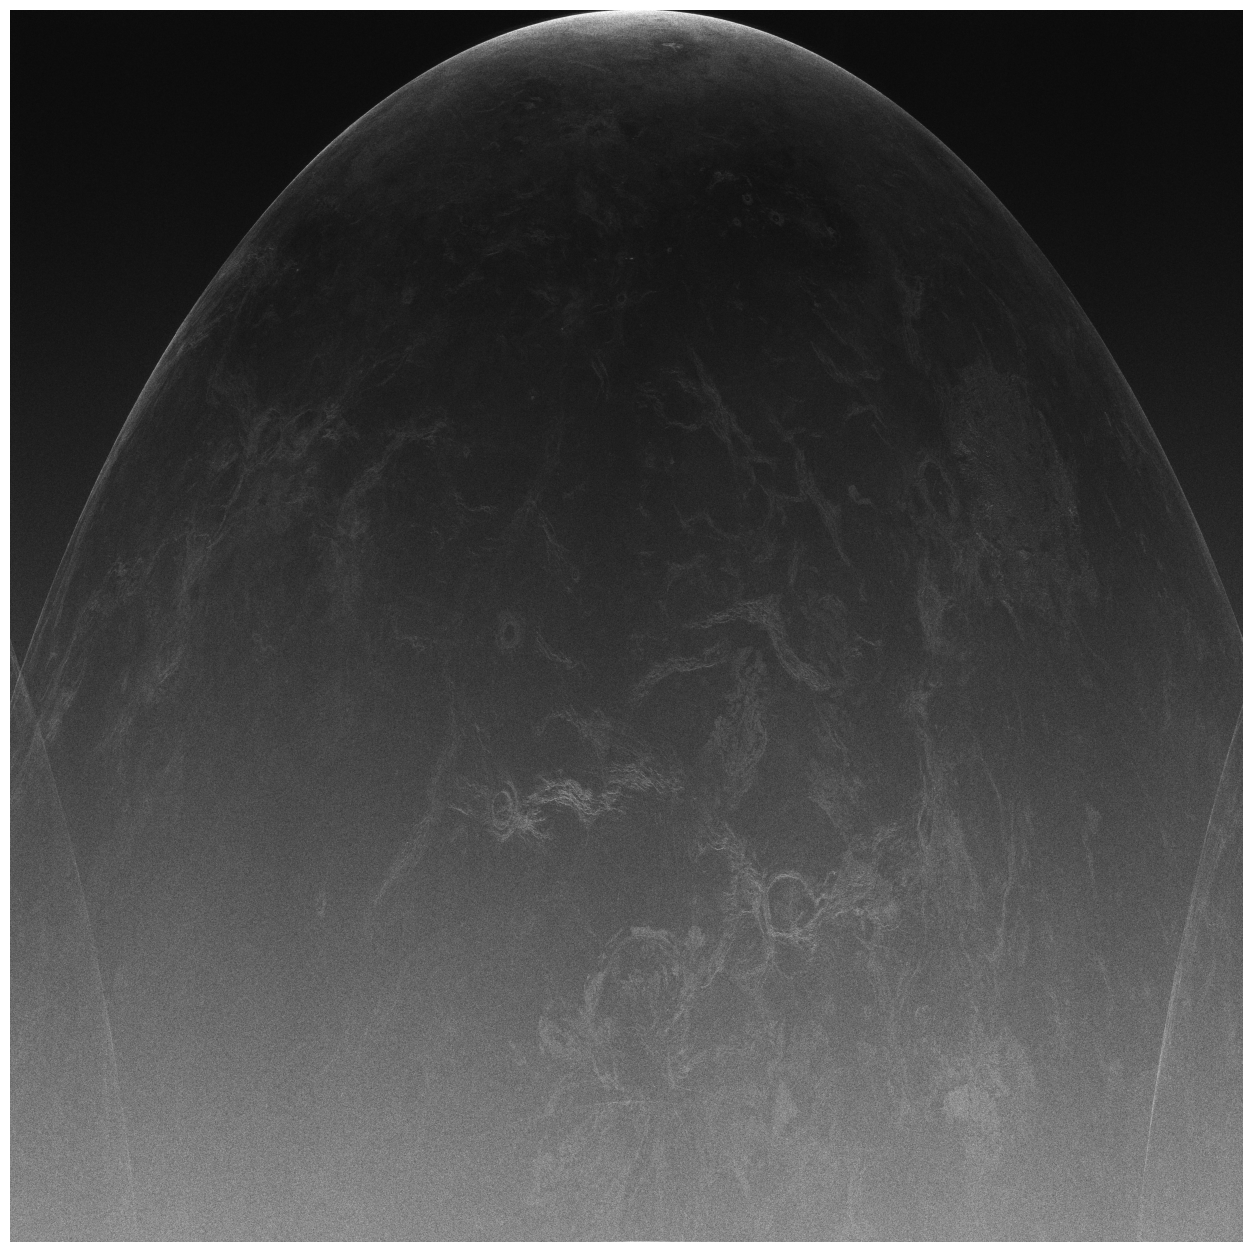

In [22]:
def coarsePreprocessDopplerDelay(img):
    c2 = img.shape[1] // 2
    ## Convert complex valued image to magnitude image.
    img_a = np.abs(img)
    ## Normalize the image    
    img_a -= img_a.min()
    img_a /= img_a.max()
    ## Roll the frequency axis (left/right) by the default so that zero doppler is in the middle of the image, and the
    # planet looks like a planet.
    # NOTE: this is NOT a fine-tuned fit but should be correct to within ~100 columns.
    img_a = np.roll(img_a, c2)
    return img_a


def coarseTuneRollup(img_a):
    c2 = img_a.shape[1] // 2
    ## Roll the range axis (up/down) so that SRP onset starts at row 0
    # First, identify the biggest peak in the center-slice of the image.
    c = np.sum(img_a[:, 3500:-3500], axis=1)
    #plt.plot(c, 'r-')
    max_c = np.argmax(c)
    # Center the biggest peak to avoid wrapping issues.
    center_i = c2 - max_c
    c = np.roll(c, center_i)
    # Find the first big increase above the noise floor
    d = np.diff(c[c2 - 200:c2 + 1])
    #plt.plot(d, 'b-')
    d_pre_std = np.std(d[:c2 - 100])  # std from samples *before* the spike
    first_i = np.argwhere(d > d_pre_std * 2)[0][0]
    # Roll the image up/down to put first onset at row 0
    return -(max_c - 200 + first_i) - 1


def finePreprocessDopperDelay(img_a):
    # TODO: improve the echo power model -- AND map it properly to the angle of incidence!
    # TODO: apply a different rule for OCP? 
    echo_power = 1 - np.cos(np.linspace(0, np.pi / 2, img_a.shape[0])) + 1e-1  # Add a litte to avoid zero.
    img_b = (img_a.T * echo_power).T

    # TODO: "noise normalize"? (Mentioned in the papers)
    #noise_patch = img[:1000,:1000]
    #average_noise = np.mean(np.abs(noise_patch))
    #print('average_noise', average_noise)
    #img_b = img_a.copy()
    #img_b -= average_noise

    # Flatten the 99th percentile
    percentile = 99
    percentile_thresh = np.percentile(img_b.ravel(), percentile)
    img_b = np.where(img_b > percentile_thresh, percentile_thresh, img_b)

    #percentile = 5
    #percentile_thresh = np.percentile(img_b.ravel(), percentile)
    #img_b = np.where(img_b < percentile_thresh, percentile_thresh, img_b)
    #if filename: plt.imsave(f"{ROOT_PREFIX}/PREPROCESS_TRIAGE/{filename[:-4]}_processed.png", img_b, cmap="gray")
    return img_b


if _interactive:
    img_a = coarsePreprocessDopplerDelay(img)
    best_rollup = coarseTuneRollup(img)
    img_a = np.roll(img_a, best_rollup, axis=0)
    img_b = finePreprocessDopperDelay(img_a)

    if 1: # debug
        from matplotlib import pyplot as plt
        #plt.imsave(filename + ".png", img_b)
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(img_b, cmap='gray')

    if 0: # debug
        from matplotlib import pyplot as plt
        #plt.imsave(filename + ".png", img_b)
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(img_b, cmap='gray')
    
    if 0:
        plt.figure(figsize=(16, 4))
        from matplotlib import pyplot as plt
        plt.hist(img_b.ravel(), bins=50)

best_col_offset=-71


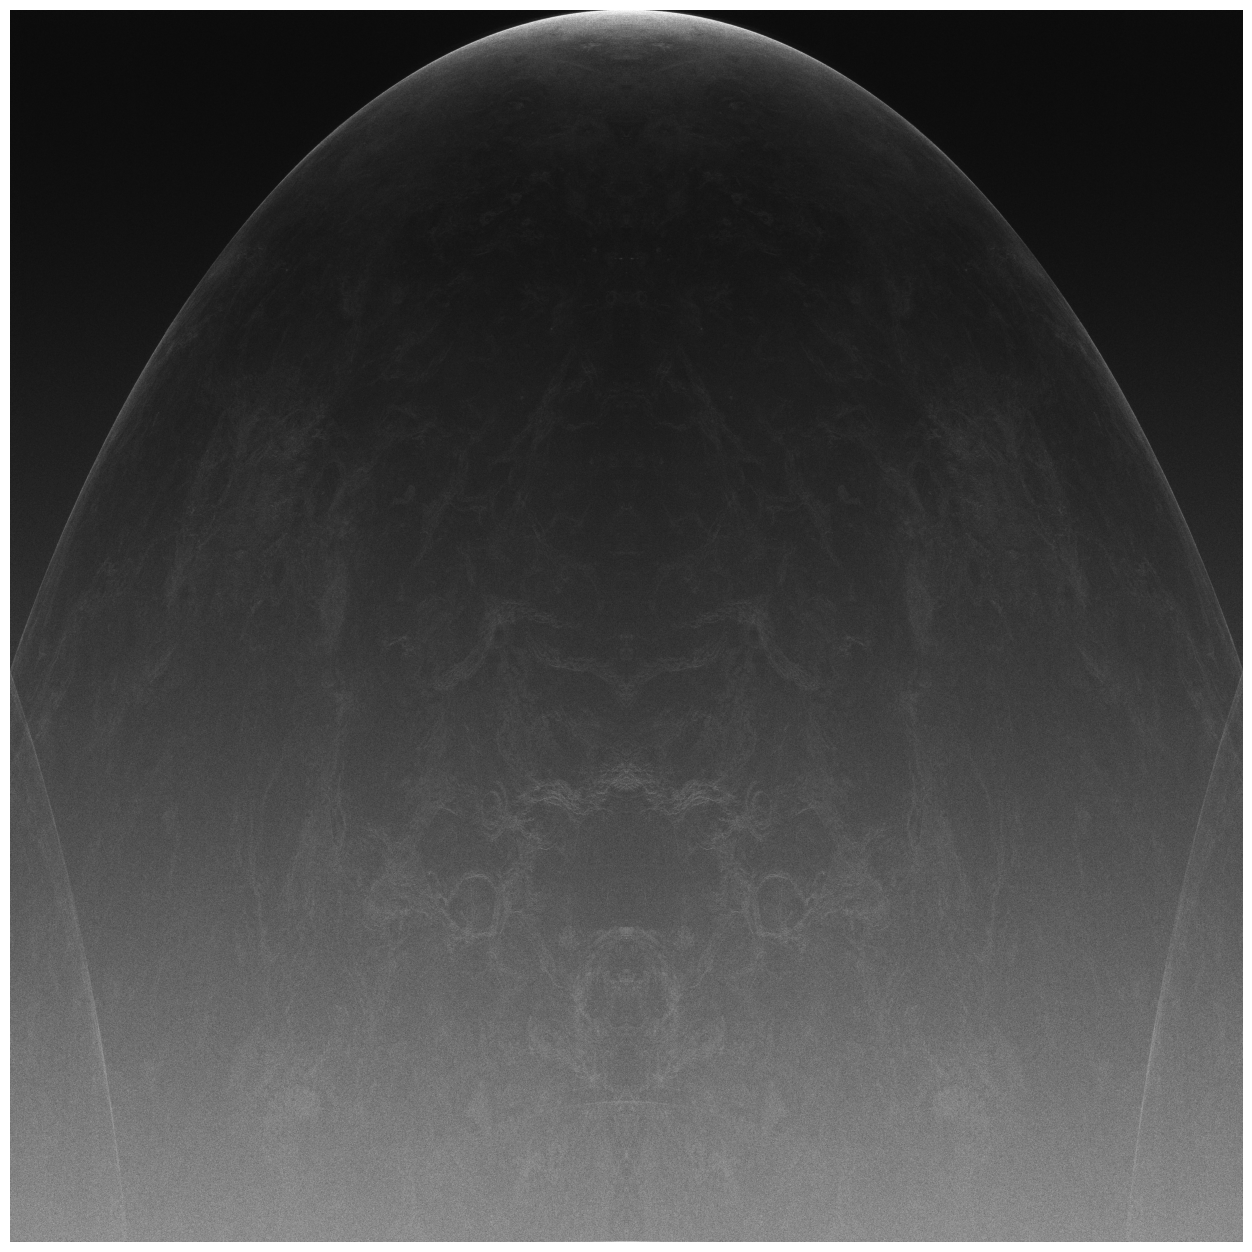

In [23]:
def coarseTuneRoll(img_b, lbl_dict, filename=None): # Coarse-tune the centering by rolling to maximize left-right symmetry
    best_col_offset = 0
    best_col_offset_sum = 0
    # Baud roughly determines the frequency spreading, so we use different windows to avoid the wrap region.
    if lbl_dict["GEO_BAUD"] == 4.2:
        img_h = img_b[2500:3000, :].copy()
    if lbl_dict["GEO_BAUD"] == 4.0:
        img_h = img_b[3000:4000, :].copy()
    elif lbl_dict["GEO_BAUD"] == 3.9:
        img_h = img_b[4000:5000, :].copy()
    elif lbl_dict["GEO_BAUD"] == 3.8:  # For 2012
        img_h = img_b[3500:4500, :].copy()
    else:
        raise("Unknown GEO_BAUD", lbl_dict["GEO_BAUD"])
    for offset in range(-100, 101):  # HUGE range?
    #for offset in range(-50, 51):  # More sane range?
        img_tmp = np.roll(img_h, offset)
        #img_tmp = np.diff(img_tmp, axis=1, prepend=0)**2
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        #img_mirror = np.diff(img_tmp[:, :1000], axis=1)**2 * np.diff(np.fliplr(img_tmp[:, -1000:]), axis=1)**2  # Difference image
        #img_mirror = img_tmp * np.fliplr(img_tmp)
        #plt.imsave(filename + '_roll' + str(offset) + '.png', img_mirror)
        #plt.imshow(img_mirror, cmap='gray')
        total_sum = np.sum(img_mirror)
        #print(offset, total_sum)
        if total_sum > best_col_offset_sum:
            best_col_offset_sum = total_sum
            best_col_offset = offset
    if filename: # debug
        img_tmp = np.roll(img_h, best_col_offset)
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        plt.imsave(f"{ROOT_PREFIX}/ROLL_TRIAGE/{filename[:-4]}_roll_{best_col_offset}.png", img_mirror)
    return best_col_offset
    
if _interactive:
    best_col_offset = coarseTuneRoll(img_b, lbl_dict)
    print(f'{best_col_offset=}')
    img_b = np.roll(img_b, best_col_offset)

    if 1: # debug
        from matplotlib import pyplot as plt
        #plt.imsave(filename + ".png", img_b)
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(img_b + np.fliplr(img_b), cmap='gray')

Best fit score: 3.1176
Best fit parameters: -1, -1, 1.2120


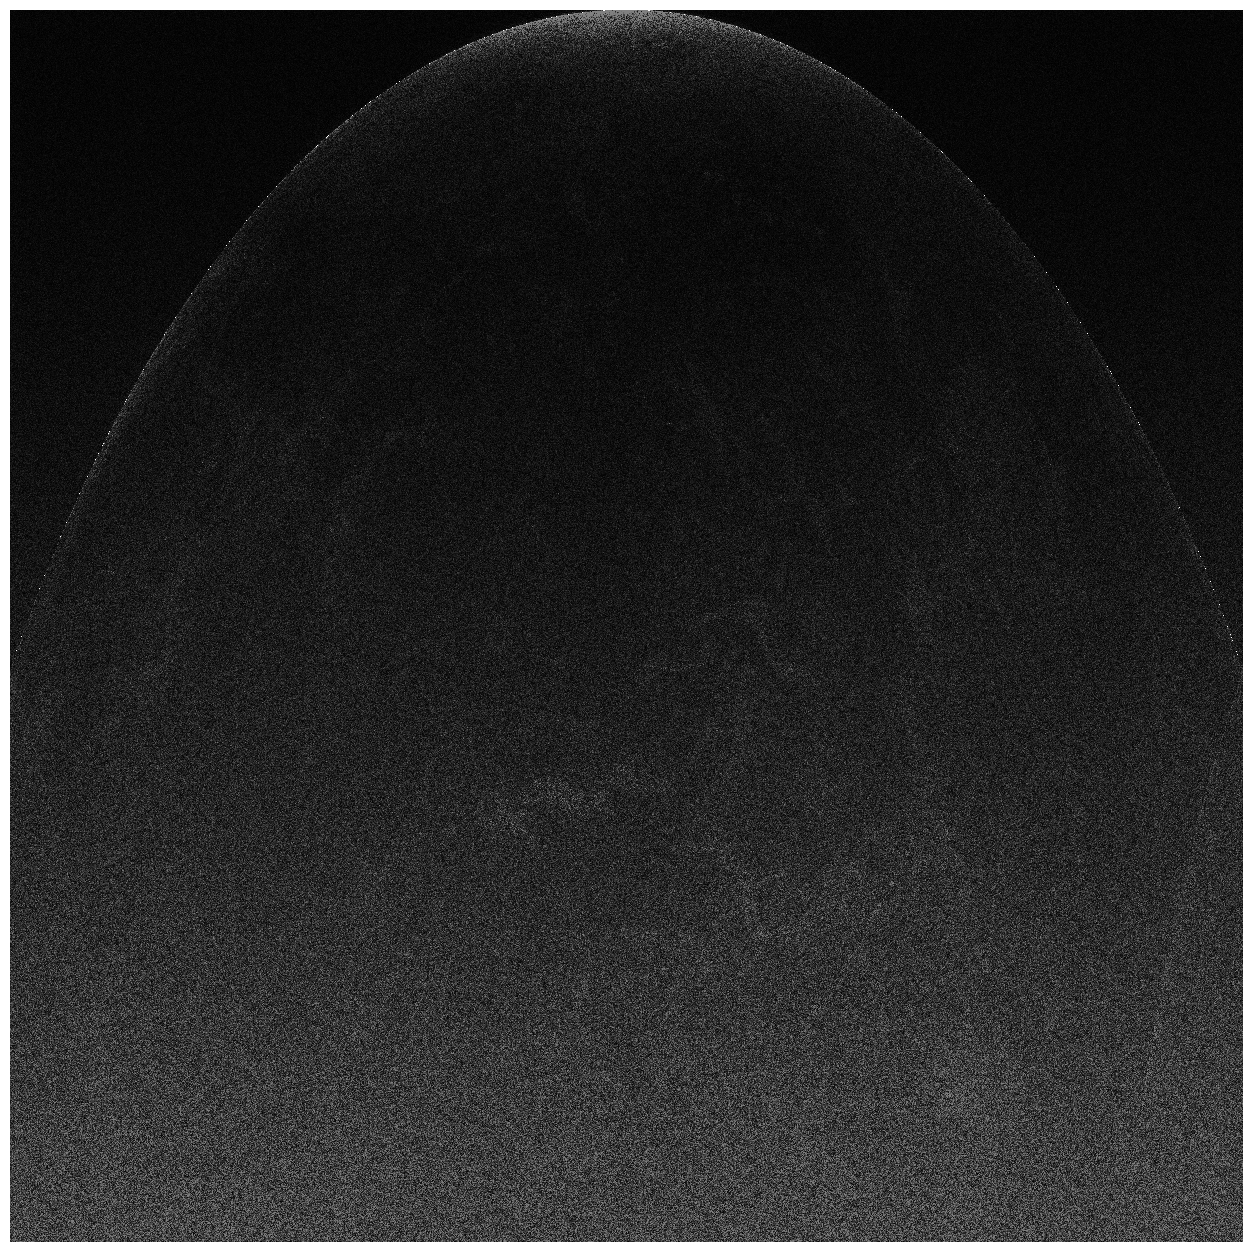

In [26]:
def fitDopplerDelayCurve(img_b, lbl_dict, filename=None):
    c2 = img_b.shape[1] / 2
    _radius_km = 6051.8
    _row_dist_km = 299792.46 * lbl_dict['GEO_BAUD'] * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
    dlon = np.linspace(-np.pi/2, np.pi/2, 8000)
    row_dist = _radius_km * (1 - np.cos(dlon)) / _row_dist_km
    sin_dlon = np.sin(dlon)

    # Grid search by looking for the best "edge"
    best_score = 0
    best_params = []
    for freq_offset in range(-3, 4):  # Small range because image has already been coarsely centered.
        for delay_offset in range(-3, 4):  # Small range because image has already been coarsely ranged.
            for freq_scale in np.linspace(0.8, 1.4, 301):
                cs = (c2 * freq_scale) * sin_dlon + (c2 + freq_offset)
                rs = row_dist + delay_offset
                rs = rs.astype('i')
                cs = cs.astype('i')
                cs2 = np.where(cs < c2, cs - 2, cs + 2)  # TODO: smarter kernel?
                row_start = 500 # NOTE: start at row_startto avoid bias due to extremely bright SRP return
                row_end = 6000  # NOTE: end at row_end to avoid noise due to frequency wrapping
                valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= row_start) & (rs < row_end)
                valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs >= row_start) & (rs < row_end)
                score = sum(img_b[rs[valid], cs[valid]]) - sum(img_b[rs[valid2], cs2[valid2]])
                if score > best_score:
                    best_score = score
                    best_params = [freq_offset, delay_offset, freq_scale]
                    #print(score, freq_offset, delay_offset, freq_scale)
    if filename:
        cs = (c2 * freq_scale) * sin_dlon + (c2 + freq_offset)
        rs = row_dist + delay_offset
        rs = rs.astype('i')
        cs = cs.astype('i')
        cs2 = np.where(cs < c2, cs - 2, cs + 2)
        valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0]) 
        valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0])   
        img_h = img_b.copy() # Scratch image
        img_h[rs[valid2], cs2[valid2]] = img_h.min() / 2
        img_h[rs[valid], cs[valid]] = img_h.max() * 2
        plt.imsave(f"{ROOT_PREFIX}/FIT_TRIAGE/{filename[:-4]}_fit_{freq_offset}_{delay_offset}_{freq_scale}.png", img_h, cmap='gray')

    return best_score, best_params

if _interactive:
    best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_b, lbl_dict)
    freq_offset, delay_offset, freq_scale = best_fit_parameters
    print(f'Best fit score: {best_fit_score:.4f}')
    print(f'Best fit parameters: {freq_offset}, {delay_offset}, {freq_scale:.4f}')
    
    if 1:  # debug
        c2 = img_b.shape[1] / 2
        _radius_km = 6051.8
        _row_dist_km = 299792.46 * lbl_dict['GEO_BAUD'] * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
        dlon = np.linspace(-np.pi/2, np.pi/2, 8000)
        cs = (c2 * freq_scale) * np.sin(dlon) + (c2 + freq_offset)
        rs = _radius_km * (1 - np.cos(dlon)) / _row_dist_km + delay_offset

        rs = rs.astype('i')
        cs = cs.astype('i')
        cs2 = np.where(cs < c2, cs - 2, cs + 2)
        valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0]) 
        valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0])   

        if 1:  # Debug image
            img_h = img_b.copy() # Scratch image
            #img_h[rs[valid], cs[valid]] = img_h.max()
            img_h[rs[valid2], cs2[valid2]] = img_h.min() / 2
            img_h[rs[valid], cs[valid]] = img_h.max() * 2
            plt.figure(figsize=(16, 16))
            plt.axis('off')
            plt.imshow(img_h, cmap='gray', interpolation='none')
            #plt.imsave(f"{ROOT_PREFIX}/FIT_TRIAGE/{filename[:-4]}_fit.png", img_h, cmap='gray')
        if 0: # Debug the curve fit.
            img_h = img_b.copy()
            #img_h = np.diff(img_c, axis=1, prepend=0)**2
            img_h[rs[valid2], cs2[valid2]] = img_h.min() / 2
            img_h[rs[valid], cs[valid]] = img_h.max() * 2
            plt.figure(figsize=(18, 12))
            plt.subplot(1,3,1)
            plt.axis('off')
            plt.imshow(img_h[4000:5000, :800], cmap='gray', interpolation='none')
            plt.subplot(1,3,2)
            plt.axis('off')
            plt.imshow(img_h[0:1000, 3000:-3000].T, cmap='gray')
            plt.subplot(1,3,3)
            plt.axis('off')
            plt.imshow(img_h[4000:5000, -800:], cmap='gray', interpolation='none')
            print('done')
        

In [ ]:
def setLLV(G, Gc, lon, lat, v):
    # lon in [0, 2*pi)
    # lat in [-pi/2, pi/2]
    r = (lon / (2 * np.pi) * G.shape[0]).astype('i')
    c = ((lat + np.pi / 2) / np.pi * G.shape[1]).astype('i')
    G[r, c] = v
    Gc[r, c] += 1

In [ ]:
if 0:  # Draw debug lines of latitude and longitude
    for lon in range(360):
        setLL(G0, lon, 0, 1)
        setLL(G0, lon, 45, 0.5)
        setLL(G0, lon, -45, 0.2)
    
    for lat in range(-90, 90, 3):
        setLL(G0, 0, lat, 1)
        setLL(G0, 90, lat, 0.5)
        setLL(G0, 180, lat, 1)
        setLL(G0, 270, lat, 0.2)
    
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(G0.T, interpolation='none')

if 0:
    #setLLV(G0, Gc, np.linspace(0, 359, 100), np.linspace(-90, 89, 100), 1)
    #setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, 1)
    setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, G.max())

In [ ]:
if 0: # debug: derive the magic doppler angle scale (freq_scale factor)
    print(freq_scale)
    (-np.arccos(freq_scale/1.035) * au.radian).to(au.degree)

In [ ]:
## Project the doppler/delay image into lon/lat
# TODO: average pixel values?

import astropy.constants as acon
import astropy.coordinates as ac
import astropy.units as au

def dopplerDelayToSphericalProjection(img_b, G, Gc, lbl_dict, SRP, fit_parameters):
    _radius_km = 6051.8
    _row_dist_km = 299792.46 * lbl_dict['GEO_BAUD'] * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
    freq_offset, delay_offset, freq_scale = fit_parameters

    # Omit "degraded data" regions due to
    # - high N/S ambiguity near the edges (first 1 deg lat), and
    # - grazing angle (last 1 deg lat and lon)
    dlon = np.linspace(-85 / 180 * np.pi, 85 / 180 * np.pi, 8000)
    if lbl_dict['GEO_POINTING'] == 'N':
        dlat = np.linspace(5 / 180 * np.pi, 85 / 180 * np.pi, 4000)  # Northern hemisphere
    else:
        dlat = np.linspace(-85 / 180 * np.pi, -5 / 180 * np.pi, 4000)  # Southern hemisphere
    dlon_mesh, dlat_mesh = np.meshgrid(dlon, dlat)

    # Omit degraded data region due to SRP (within 7 deg of the center)
    mesh_valid = np.sqrt(dlat_mesh**2 + dlon_mesh**2) > (7 / 180 * np.pi)
    dlon_mesh = dlon_mesh[mesh_valid]
    dlat_mesh = dlat_mesh[mesh_valid]

    c2 = img_b.shape[1] / 2
    cs = freq_scale * np.cos(dlat_mesh) * np.sin(dlon_mesh) * c2 + c2 + freq_offset
    rs = _radius_km * (1 - np.cos(dlon_mesh) * np.cos(dlat_mesh)) / _row_dist_km + delay_offset

    rs = rs.astype('i')
    cs = cs.astype('i')
    valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0])   
    
    start_astrotime = SRP['start_astrotime']
    SRP_lon_deg = SRP['ephemerides']['PDObsLon'][0]
    SRP_lat_deg = SRP['ephemerides']['PDObsLat'][0]

    if 0: # No SRP transform: as if the SRP were (0, 0)
        setLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

    if 0: # Transformed to the SRP, no rotation.
        # NOTE: this doesn't wrap latitude over the top... but that is probably ok given the max apparent inclination of
        # Venus is only about 10 degrees.
        p0 = ac.SkyCoord(SRP_lon_deg * au.deg, SRP_lat_deg * au.deg)
        PP = p0.spherical_offsets_by(dlon_mesh * au.rad, dlat_mesh * au.rad)
        setLLV(G, Gc, PP.data.lon.rad.ravel()[valid], PP.data.lat.rad.ravel()[valid], img_b[rs[valid], cs[valid]])

    if 1: # Transformed to the SRP and rotated by the "doppler angle"
        # Convert to unit spheroid cartesian coordinates.
        cdlat_mesh = np.cos(dlat_mesh)
        X = np.matrix((cdlat_mesh * np.cos(dlon_mesh),
                      cdlat_mesh * np.sin(dlon_mesh),
                      np.sin(dlat_mesh)))

        # The S matrix rotates the coordinate system to center the SRP.
        clon = np.cos(SRP_lon_deg / 180 * np.pi)
        clat = np.cos(SRP_lat_deg / 180 * np.pi)
        slon = np.sin(SRP_lon_deg / 180 * np.pi)
        slat = np.sin(SRP_lat_deg / 180 * np.pi)
        S = np.matrix((( clon * clat,  slon * clat, slat),
                       (       -slon,         clon,    0),
                       (-clon * slat, -slon * slat, clat))) 

        ## The D matrix rotates the coordinates about the x' = x'' axis by the Doppler angle:
        doppler_ang = apparentRotationAngle_poliastro(start_astrotime)
        cnp = np.cos(doppler_ang.to(au.radian))
        snp = np.sin(doppler_ang.to(au.radian))
        D = np.matrix(((1,   0,    0),
                       (0, cnp, -snp),
                       (0, snp,  cnp))) 

        X = (S.T * D.T) * X
    
        # Convert back to lat/lon
        dlat_mesh = np.arcsin(X[2].A)[0]
        dlon_mesh = np.arctan2(X[1].A, X[0].A)[0]
        setLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

if _interactive:
    G = np.zeros((16000, 8000), dtype='f') # TODO: use a smaller data rep?
    Gc = np.zeros(G.shape, 'int')
    dopplerDelayToSphericalProjection(img_b, G, Gc, lbl_dict, SRP, best_fit_parameters)

    # debug
    Gm = np.divide(G, Gc, where=Gc>0)
    print(filename)

    if 1:
        plt.figure(figsize=(20, 10))
        plt.axis('off')
        plt.imshow(Gm.T[::4, ::4], cmap='gray', origin='lower')
        #plt.imshow(G.T[::4, ::4], cmap='gray', origin='lower')
        #plt.imshow(G.T, cmap='gray', origin='lower') # , interpolation='none')

    if 1:
        plt.imsave(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{filename[:-4]}_global.png", Gm.T[::1, ::1], origin='lower')


In [ ]:
from matplotlib import pylab as plt
import numpy as np
import os
import pickle


FILTER_PREFIX = ROOT_PREFIX + "ROLL_GOOD/"
#FILTER_PREFIX = ROOT_PREFIX + "ROLL_BAD/"
FILTER = set()
filenames = os.listdir(FILTER_PREFIX)
for filename in filenames:
    FILTER.add(filename[:25])

ROLLUP_CACHE = {}
filenames = os.listdir(ROOT_PREFIX + "ROLLUP_GOOD/")
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[33:].split('.')[0])
    ROLLUP_CACHE[filename[:25]] = r

ROLL_CACHE = {}
filenames = os.listdir(ROOT_PREFIX + "ROLL_GOOD/")
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[31:].split('.')[0])
    ROLL_CACHE[filename[:25]] = r


def processDopplerDelayImage(filename):

    if not filename[:25] in FILTER: return

    print('Processing', filename)

    img = np.memmap(DATA_PREFIX + filename, dtype='<F', shape=(8191, 8192), mode='r')  # 'F' is complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.

    lbl_dict = parseLbl(filename)

    SRP = pickle.load(open(DATA_PREFIX + filename[:-4] + '_horizons.pkl', 'rb'))

    # HACK: 1988 data seems to have flipped doppler?
    if lbl_dict['START_TIME'].startswith('1988'): img = np.fliplr(img)

    # First do basic image processing: convert to magnitude from complex, and normalize.
    img_a = coarsePreprocessDopplerDelay(img)

    # Second, coarse tune the range (rollup)
    #best_rollup = coarseTuneRollup(img_a)
    best_rollup = ROLLUP_CACHE[filename[:25]]  # Use cached rollup
    img_a = np.roll(img_a, best_rollup, axis=0)

    # Third, fine process (which requires a tuned rollup)
    img_b = finePreprocessDopperDelay(img_a)

    # Fourth, tune the symmetry (roll)
    #best_roll = coarseTuneRoll(img, lbl_dict, filename)
    best_roll = ROLL_CACHE[filename[:25]]  # Use cached roll
    img_b = np.roll(img_b, best_roll)

    best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_b, lbl_dict, filename)

    ## Create new global map image and count image
    G = np.zeros((16000, 8000), dtype='f') # TODO: use a smaller data rep?
    Gc = np.zeros(G.shape, 'int')

    dopplerDelayToSphericalProjection(img_b, G, Gc, lbl_dict, SRP, best_fit_parameters)

    Gm = np.divide(G, Gc, where=Gc>0)
    plt.imsave(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{filename[:25]}.png", Gm.T[::1, ::1], origin='lower')

## Batch and commandline processing...

In [ ]:
#processDopplerDelayImage("venus_scp_20150811_174505.img")
#processDopplerDelayImage("venus_ocp_20150816_171104.img")
#processDopplerDelayImage("venus_ocp_19880617_151830.img")

In [ ]:
if 0: ## Batch processing in notebook
    import os
    
    for filename in os.listdir(DATA_PREFIX):
        if not filename.endswith('.img'): continue
        #if not '_2012' in filename: continue
        if not '_2001' in filename: continue
        processDopplerDelayImage(filename)


In [ ]:
## Main function to allow being run from the command-line.
import sys

if __name__ == '__main__' and "get_ipython" not in dir():  # Not imported, not run from Jupyter/IPython
    args = sys.argv[1:]
    #print('args', args)
    processDopplerDelayImage(args[0])
    sys.exit()

In [ ]:
## Parallel magic.

## 1. Convert to .py with (from "My Drive/Colab Notebooks" directory):
#%cd "/mnt/g/My Drive/Colab Notebooks"
%cd "/mnt/c/Users/natha/code/venera"
! jupyter nbconvert --to python Venera\ -\ Radar.ipynb

## 2. Run the .py in parallel (from the venus data directory):
%cd $DATA_PREFIX
#! ls -1 *2017*.img | xargs -n 1 -P 4 python3 /home/than/My\ Drive/Colab\ Notebooks/Venera\ -\ Radar.py
! ls -1 *.img | xargs -n 1 -P 4 python3 /mnt/c/Users/natha/code/venera/Venera\ -\ Radar.py